# **Material Search**

> This notebook is to be used for the Data Science MSc Thesis of Gustavo Fonseca. Data is provided by Mota Engil and should support the Supply Chain in the Mota-Engil group.

---

## **Introduction**

**Objective**: cluster the materials by similarity to each other. Ideally we are going to be able to categorize according to the similarity of the materials.

I start by:
1. Exploring the dataset and showing why I end up not using a lot of information;
2. Test levenshtein distance betweeen words and custom distance metric for sentences that uses word levenshtein distance;
3. Optimize the code in order to be able to process all the materials;
4. Apply it to DBScan to obtain clusters.

## **Imports**

In [1]:
# Imports to get data from Azure
import json
import pyodbc
import textwrap

# Standard imports
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import editdistance as ed
from collections import Counter
import unicodedata as unic
import re

# Text Processing
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Clustering models
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# MP for distance calculation
from multiprocessing import cpu_count, Pool, sharedctypes

import locale
print(locale.getpreferredencoding())
%matplotlib inline

UTF-8


## **Connect and Extract the data from Azure SQL Database**

Connect to SQL Database to Extract the data. I use an SQL Query to get more information from the materials.

In [2]:
GET_DATA = False

if GET_DATA:
    
    with open('variables/variables.json') as f:
          vars_ = json.load(f)


    # Specify the Driver.
    driver = '{ODBC Driver 17 for SQL Server}'

    # Specify Server Name and Database Name.
    server_name = vars_['server_name']
    database = vars_['database']

    # Create our Server URL.
    server = f'{server_name}.database.windows.net,1433'

    # Define Username & Password # TODO
    login = vars_['login']
    password = vars_['password']

    # Create the full connection string.
    connection_string = textwrap.dedent(f'''
        Driver={driver};
        Server={server};
        Database={database};
        Uid={login};
        Pwd={password};
        Encrypt=yes;
        TrustServerCertificate=no;
        Connection Timeout=30;
    ''')

    # Create a new PYODBC Connection Object
    cnxn: pyodbc.Connection = pyodbc.connect(connection_string)

    # Create a new Cursor Object from the connection
    crsr: pyodbc.Cursor = cnxn.cursor()

    # Define a select Query.
    select_sql = """SELECT zmm001.Material, 
    CAST(zmm001.MaterialDescription AS VARCHAR(MAX)) AS MaterialDescription, 
    zmm001.MaterialGroup, 
    CAST(zmm001.MaterialGroupDescription AS VARCHAR(MAX)) AS MaterialGroupDescription, 
    zmm001.Unit, 
    zmm001.MaterialType, 
    zmm001.Created, 
    zmm001.LastChange, 
    ISNULL(AVG(mb51view.ValuePerUnit), '0') as AveragePrice,
    ISNULL(STDEV(mb51view.ValuePerUnit), '0') as STDPrice,
    ISNULL(COUNT(mb51view.ValuePerUnit), '0') as CountMovements
    FROM [PPP].[ZMM001] as zmm001
    LEFT JOIN (
    SELECT Material, MovementValueEuro / Quantity AS ValuePerUnit
    FROM [PPP].[MB51view]
    WHERE Quantity > 0
    ) as mb51view
    ON mb51view.Material=zmm001.Material
    GROUP BY
    zmm001.Material,
    CAST(zmm001.MaterialDescription AS VARCHAR(MAX)),
    zmm001.MaterialGroup,
    CAST(zmm001.MaterialGroupDescription AS VARCHAR(MAX)),
    zmm001.Unit,
    zmm001.MaterialType,
    zmm001.Created,
    zmm001.LastChange
    """

    # Read to Pandas
    data = pd.read_sql(select_sql, cnxn)

    # Close the connection once we are done
    cnxn.close()
    
    data['Created'] = pd.to_datetime(data['Created'])
    data['LastChange'] = pd.to_datetime(data['LastChange'])
    data = data.replace(['', 'null', '#N/A'], [np.nan, np.nan, np.nan])
    
    data.to_csv('data/material_data.csv', index=False)

else:
    
    data = pd.read_csv(
        'data/material_data.csv', 
        dtype={
            'Material': str, 
            'MaterialDescription': str, 
            'MaterialGroup': str, 
            'MaterialGroupDescription': str, 
            'Unit': str, 
            'MaterialType': str, 
            'Created': str, 
            'LastChange': str,
            'AveragePrice': float,
            'STDPrice': float,
            'CountMovements': int
        },
        parse_dates=['Created', 'LastChange'])

## **Data Exploration**

This section is focused in analysing the data and seeing their worth for the purpose of this project. We want data that would allow to calculate similarities between the materials

In [3]:
data_p = data.copy()
data_p.head()

,Material,MaterialDescription,MaterialGroup,MaterialGroupDescription,Unit,MaterialType,Created,LastChange,AveragePrice,STDPrice,CountMovements
0,100001,G OFFICE FURNITURE,259807,Several Services,UN,ZSUB,2019-12-26,2021-05-02,0.0,0.0,0
1,100008,G BRICK MASONRIES,200101,Brick Masonries,UN,ZSUB,2019-12-08,2021-03-19,0.0,0.0,7
2,100009,G CONCRETE BLOCKS MASONRY,200102,Concrete Bolcks Masonry,UN,ZSUB,2019-12-08,2021-01-14,0.0,0.0,92
3,100012,G REINFORCING STEEL,200301,Reinforcing Steel,UN,ZSUB,2019-12-10,2021-05-02,0.0,0.0,21
4,100014,G EXTERIOR ARRANGEMENTS,200401,Exterior Arrangements,UN,ZSUB,2019-12-08,2021-05-02,0.0,0.0,70


We start by fixing some found description problems:
* Spacing
* NaNs

In [4]:
# Change 2 spacings to 1 spacing
data_p = data_p.replace('\s{2,}', ' ', regex=True)

# NaN to None
data_p = data_p.replace({np.nan: None})

Get some general statistics for each of the columns

In [5]:
# Get the cardinality and number of null values for each column

# Material is primary key therefore it is never null

cols_to_check = [
    'MaterialDescription',
    'MaterialGroup',
    'MaterialGroupDescription',
    'Unit',
    'MaterialType',
    'Created',
    'LastChange',
]

cols_numbers = [
    'AveragePrice',
    'STDPrice',
    'CountMovements'
]

stats_data = np.empty([len(cols_to_check) +  len(cols_numbers), 6], dtype=int)
types = []
nr_words = []

for i, col in enumerate(cols_to_check):
    stats_data[i, :] = [len(data_p[col].unique()), (data_p[col].isnull()).sum(), (data_p[col]=='').sum(), 0, 0, 0]
    types.append(data[col].dtype)
    
for i, col in enumerate(cols_numbers):
    stats_data[i + 7, :] = [len(data_p[col].unique()), (data_p[col].isnull()).sum(), (data_p[col]=='').sum(), (data_p[col]==0).sum(), int(data_p[col].min()), int(data_p[col].max())]
    types.append(data[col].dtype)
    
stats_data = pd.DataFrame(stats_data, columns=['Cardinality', 'Nulls', 'Blank', 'Zeros', 'Min', 'Max'], index=cols_to_check+cols_numbers)
stats_data['Dtype'] = types


for col in ['Created', 'LastChange']:
    stats_data.loc[col, 'Min'] = data_p[col].dt.date.min()
    stats_data.loc[col, 'Max'] = data_p[col].dt.date.max()

stats_data.head(10)

,Cardinality,Nulls,Blank,Zeros,Min,Max,Dtype
MaterialDescription,142585,1169,0,0,0,0,object
MaterialGroup,819,0,0,0,0,0,object
MaterialGroupDescription,676,100,0,0,0,0,object
Unit,40,0,0,0,0,0,object
MaterialType,7,0,0,0,0,0,object
Created,416,0,0,0,2018-12-17,2021-04-26,datetime64[ns]
LastChange,321,0,0,0,2019-04-12,2021-12-03,datetime64[ns]
AveragePrice,110169,0,0,117064,0,383602,float64
STDPrice,53317,0,0,181481,0,234276,float64
CountMovements,258,0,0,89490,0,4510,int64


AveragePrice and STDPrice have both a lot of zeros, which are indicative of no price information. These 0s represent more than 50% of the data. So I will proceed with eliminating these columns.

In [6]:
data_p.drop(columns=['AveragePrice', 'STDPrice'], inplace=True) # delete columns

The dates of creation and change can be indicative of similar seasonal needs but with so many diverse projects happening at the same time, it is also risky trying to infer anything with it.

In [7]:
data_p.drop(columns=['Created', 'LastChange'], inplace=True)

A very big percentage of materials have no registered movement, therefore it should also be hard to cluster using this information. In any case this data can be used to sort the results from the material search in the end.

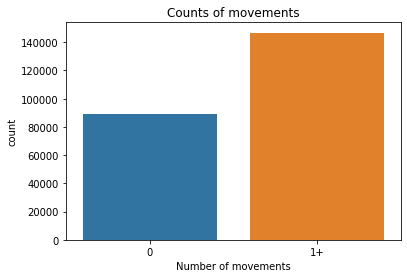

In [8]:
data_p['movements_category'] = data_p['CountMovements'].apply(lambda x: '0' if x < 1 else '1+')
ax = sns.countplot(data=data_p, x='movements_category')
ax.set_xlabel('Number of movements')
ax.set_title('Counts of movements');

In [9]:
data_p.drop(columns=['CountMovements', 'movements_category'], inplace=True)

We can also delete the units. Sometimes they vary because users prefer to deal e.g. with liters instead of units and that should not distanciate the different materials.

In [10]:
data_p.drop(columns=['Unit'], inplace=True)

In [ ]:
# End result
data_p.head()

**Outcome**
We will calculate distances between the material descriptions.

After several meetings we obtained the knowledge that searches are done using two types of information: 1) Tools & Equipment part number, and 2) Material description. In this case we will filter only materials (ZMAT) from the dataset which are what users search for using the descriptions.

In [12]:
# Keep only ZMAT & ZPEC
data_p = data_p[(data_p.MaterialType=='ZMAT')].copy()

MaterialGroup is the MaterialGroupDescription ID, and Material Type we have only two groups so we will eliminate both of these columns.

In [13]:
data_p.drop(columns=['MaterialGroup', 'MaterialType'], inplace=True)

Material Group and Type information are both already clustered groups of data, and we can use them to calculate evaluation metrics with pseudo ground truth. They won't be reliable since they have mixed types of groups: some are grouped by the brand (e.g. Volvo and Toyota) and others are grouped by their utility.

In [14]:
# We will save the MaterialGroupDescription for evaluating the results after
ground_truth = data_p['MaterialGroupDescription']
data_p.drop(columns=['MaterialGroupDescription'], inplace=True)

# **Calculating Distances**

Levenshtein Distance for words and increased distance in case the exact words or similar are also not present in the other string.

### Data Cleaning

First we create a new column with the cleaned up description.

In [ ]:
# first we turn the description into a cleaned version

# function to extract type of word
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


# multiple functions to clean the t
def clean_text(text):
    # clean any unicode formatting left
    text = unic.normalize("NFKD", text)
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # replace the rest of the punctuation by space
    text = ' '.join(text)
    text = [w for w in re.split('\.|\-|\s|\,|\(|\_|\d', text)]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words | Not really needed
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty
    text = [t for t in text if len(t) > 1]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0],  get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 2]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
data_p["description_clean"] = data_p["MaterialDescription"].apply(lambda x: clean_text(x) if x is not None else "")
data_p.head()

Now that we have the cleaned up descriptions, we can see what are the most common words in them.

In [ ]:
# Top 10 words after cleaning
top10words_df = pd.DataFrame(Counter(" ".join(data_p["description_clean"]).split()).most_common(10), columns=['Words', 'Occurences'])
plt.figure(figsize=(10,5))
ax = sns.barplot(data=top10words_df, x='Words', y='Occurences')
ax.set_title('Top 10 words in the descriptions')
plt.savefig('images/top10words.png');

Since the cleanup returned empty strings for some materials, we will consider them undefined materials

In [17]:
# missing description will be set to undefined
data_p.loc[data_p.description_clean.str.contains('^\s*$'), 'description_clean'] = 'undefined'

Now that we have clean descriptions, we can now focus on calculating distances between the different texts with the levenshtein distance both for words and then for sentences.

### **Levenshtein distance for words**

For the levenshtein distance we have a custom function:

In [18]:
def levenshtein_dist_word(token1, token2):
    """Levenshtein distance for words."""
    
    m = len(token1)
    n = len(token2)
    
    distances = np.zeros((m + 1, n + 1))
    
    
    for t1 in range(m + 1):
        distances[t1][0] = t1
    for t2 in range(n + 1):
        distances[0][t2] = t2
            
    for t1 in range(1, m + 1):
        for t2 in range(1, n + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                insertion = distances[t1][t2 - 1]
                deletion = distances[t1 - 1][t2]
                substitution = distances[t1 - 1][t2 - 1]
                
                
                if (insertion <= deletion and insertion <= substitution):
                    distances[t1][t2] = insertion + 1
                elif (deletion <= insertion and deletion <= substitution):
                    distances[t1][t2] = deletion + 1
                else:
                    distances[t1][t2] = substitution + 1
        
    final_dist = distances[-1][-1]
    lword = max(m,n)
    
    # ratio = (lword - final_dist) / lword # Calculate much of the word has changed
    
    # Some words are incomplete so we check the matrix to see if there is any word
    # that is the incomplete version of the other.
    
    # if (np.any(distances[:,-1]==0)) or (np.any(distances[-1,:]==0)):
    #    ratio = 0.9
        
    # print_distances(distances, m, n)
    
    return final_dist

In [19]:
%%time

levenshtein_dist_word('amazingfantasticoulosimundo', 'amazcoulosimundo')

CPU times: user 481 µs, sys: 35 µs, total: 516 µs
Wall time: 505 µs


11.0

There are also some other alternatives, such as the `editdistance.eval` levenshtein distance, tested below:

In [20]:
%%time

ed.eval('amazingfantasticoulosimundo', 'amazcoulosimundo')

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 13.4 µs


11

`editdistance` package is implemented in Cython and C++ which makes it way faster than the manually implemented one. So we will continue with the editdistance levenshtein distance calculation.
The next function uses this function inside a sentence distance function to determine if a word is similar enough to another. In the sentence, the order of the words does not matter and this function reflects that.

In [21]:
def dist_sentence(token1, token2):
    """Distance for sentence adapted from levenshtein but with no fixed order."""
    initial = token1 + '|' + token2
    
    token1 = token1.split(' ')
    token2 = token2.split(' ')
        
    m = len(token1)
    n = len(token2)
    
    if (m == 0) or (n == 0):
        return 0
    
    ln = max(m, n)
    ln_max = ln
    
    # Remove identical words before checking if words are similar.
    to_remove = []
    for c in token1:
        if c in token2:
            to_remove.append(c)
    
    for c in set(to_remove):
        token1.remove(c)
        token2.remove(c)
        ln -= 1
        n -= 1
        m -= 1
        
    
    
    # Initialize distance variable
    distance = 0
    
    # Find similar words
    for i, s1 in enumerate(token1):
        if token2:
            values = np.zeros((1, n))
            for j, s2 in enumerate(token2):
                l_word = max(len(s1),len(s2))
                values[0,j] = ed.eval(s1, s2) / l_word
            try:
                value = np.amin(values)
            except:
                print(initial)
            if value < 0.33:
                index = np.argmax(values)
                # Add relative leven distance to distance
                distance += value
                # Remove the tokens
                token1.remove(token1[i])
                token2.remove(token2[index])
                ln -= 1
                n -= 1
    
    # Add the missing values that weren't matched
    distance += ln
    
    return int((distance / ln_max) * 100)

In [22]:
# Example

distance = dist_sentence("horse likes water", "morse likes milk")
print(f"Distance between 'horse likes water' and 'morse likes milk' is {distance}")

Distance between 'horse likes water' and 'morse likes milk' is 40


For calculating the distance between descriptions:
* gives a penalty of 1 for each different word, in this last example we have one different word.
* gives a partial penalty [0,1] when it has one similar word (morse -> horse) this is a normalized penalty according to the max word length. For this case we have one letter substitution from a five letter word therefore -> 0.2 of the word. Summed up we have 1 + 0.2 = 1.2. Then we divide the max number of words by this sum, so it is 3 / 1.2 = 0.4. To obtain an int8 distance matrix to save memory, we multiply the value by 100 and change to INT value. 

### **Testing Distance Matrix calculation**

### Single processing test

In [23]:
# Extract data
X = np.asarray(data_p['description_clean'].head(1000))

# Create the final output table to fill in
FINAL_OUTPUT = np.zeros((len(X),len(X)), dtype=np.int8)

In [24]:
def apply_leven(i, data):
    """Single processing function to apply sentence distance calculation."""
    
    # Only calculate distance matrix for the required values,
    # because the matrix is symetrical and the diagonal results are all 0
    j_start = i + 1
    s1 = data[i]
    for j, s2 in enumerate(data):
        if j < j_start:
            FINAL_OUTPUT[i,j] = 0
        else:
            FINAL_OUTPUT[i,j] = dist_sentence(s1, s2)

In [25]:
%%time

# Apply function with a for loop
for i in range(len(X)):
    apply_leven(i, X)

CPU times: user 10.2 s, sys: 8.07 ms, total: 10.3 s
Wall time: 10.3 s


In [26]:
# Fill in the rest of the matrix
FINAL_OUTPUT += FINAL_OUTPUT.T

In [27]:
print(FINAL_OUTPUT)

[[  0 100 100 ... 100 100 100]
 [100   0 100 ... 100 100 100]
 [100 100   0 ... 100 100 100]
 ...
 [100 100 100 ...   0  66 100]
 [100 100 100 ...  66   0 100]
 [100 100 100 ... 100 100   0]]


### Multiprocessing test to improve speed

In [28]:
# Create the matrix and make it a shared array to be accessed by the different workers
FINAL_OUTPUT_RAW = np.zeros((len(X), len(X)), dtype=np.int8)
C_TYPE_OUTPUT = np.ctypeslib.as_ctypes(FINAL_OUTPUT_RAW)
SHARED_ARRAY = sharedctypes.RawArray(C_TYPE_OUTPUT._type_, C_TYPE_OUTPUT)

In [29]:
def apply_leven_mp(i, data):
    """Multiprocessing function to apply sentence distance calculation."""
    j_start = i + 1
    s1 = data[i]
    
    # Get the shared array
    TMP = np.ctypeslib.as_array(SHARED_ARRAY)

    for j, s2 in enumerate(data):
        if j < j_start:
            TMP[i, j] = 0
        else:
            TMP[i, j] = dist_sentence(s1, s2)

In [30]:
%%time

pool = Pool(processes=cpu_count())
args = [(i, X) for i in range(len(X))]
res = pool.starmap(apply_leven_mp, args)
FINAL_OUTPUT_MP = np.ctypeslib.as_array(SHARED_ARRAY)

CPU times: user 63.4 ms, sys: 84 ms, total: 147 ms
Wall time: 2.22 s


In [31]:
# Fill in the rest of the matrix
FINAL_OUTPUT_MP += FINAL_OUTPUT_MP.T

In [32]:
if (FINAL_OUTPUT==FINAL_OUTPUT_MP).all():
    print("Matrices are the same!")

Matrices are the same!


### Using DBSCAN Processing

We will still apply DBSCAN in the next section, but before proceding we are going to show how the distance function could be applied to `sklearn.cluster.dbscan` metric parameter

In [33]:
%%time
# Function to get the strings using integers for their index in dataset
def lev_metric(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return dist_sentence(X[i], X[j])


X_ints = np.arange(len(X)).reshape(-1, 1)

db = DBSCAN(eps=90, min_samples=1, metric=lev_metric).fit(X_ints)

CPU times: user 22.3 s, sys: 124 ms, total: 22.5 s
Wall time: 22.3 s


In [34]:
%%time
## We can also try using all the processors with the parameter n_jobs
db = DBSCAN(eps=90, min_samples=1, metric=lev_metric, n_jobs=-1).fit(X_ints)

CPU times: user 30 s, sys: 2.73 s, total: 32.7 s
Wall time: 26.8 s


Interestingly, the DBSCAN processing with all processors seems to take more time, this might be because it is not taking proper advantage of using it with this function and should be getting a big penalty from the overhead.
To better understand these variations, the following section will obtain the performance gains with each of the variations.

### Measuring Performance

In [37]:
import time

sizes = [10,20,50,100,200,300, 400, 500, 600, 700, 800, 900, 1000,1500, 2000]
times_simple = []
times_mp = []
times_dbscan = []
times_dbscan_mp = []

for size in sizes:
    print(f"======================PROCESS SIZE {size} =======================")
    # Simple processing
    X = np.asarray(data_p['description_clean'].head(size))
    
    start = time.time()
    FINAL_OUTPUT = np.zeros((len(X),len(X)), dtype=np.int8)
    
    for i in range(len(X)):
        apply_leven(i, X)
    
    FINAL_OUTPUT += FINAL_OUTPUT.T
    DBSCAN(eps=90, min_samples=1, metric="precomputed").fit(FINAL_OUTPUT_MP)
    end = time.time()
    times_simple.append(end-start)
    print(f"Time to process size {size} with one process was: {end-start:.6}s.")

    
    # Multiprocessing
    start = time.time()
    FINAL_OUTPUT_RAW = np.zeros((len(X), len(X)), dtype=np.int8)
    C_TYPE_OUTPUT = np.ctypeslib.as_ctypes(FINAL_OUTPUT_RAW)
    SHARED_ARRAY = sharedctypes.RawArray(C_TYPE_OUTPUT._type_, C_TYPE_OUTPUT)
    
    pool = Pool(processes=cpu_count())
    args = [(i, X) for i in range(len(X))]
    res = pool.starmap(apply_leven_mp, args)
    FINAL_OUTPUT_MP = np.ctypeslib.as_array(SHARED_ARRAY)
    
    FINAL_OUTPUT_MP += FINAL_OUTPUT_MP.T
    DBSCAN(eps=90, min_samples=1, metric="precomputed").fit(FINAL_OUTPUT_MP)
    end = time.time()
    times_mp.append(end-start)
    print(f"Time to process size {size} with MP was: {end-start:.6}s.")
    
        
    if (FINAL_OUTPUT==FINAL_OUTPUT_MP).all():
        print("Matrices are the same!")
        
    
    # SKLean DBSCAN processing
    start = time.time()
    X_ints = np.arange(len(X)).reshape(-1, 1)
    DBSCAN(eps=90, min_samples=1, metric=lev_metric).fit(X_ints)
    end = time.time()
    times_dbscan.append(end-start)
    print(f"Time to process size {size} with DBSCAN singleprocessing was: {end-start:.6}s.")
    
    
    # SKLean DBSCAN Multiprocessing
    start = time.time()
    X_ints = np.arange(len(X)).reshape(-1, 1)
    DBSCAN(eps=90, min_samples=1, metric=lev_metric, n_jobs=-1).fit(X_ints)
    end = time.time()
    times_dbscan_mp.append(end-start)
    print(f"Time to process size {size} with DBSCAN MP was: {end-start:.6}s.")

======================PROCESS SIZE 10 =======================
Time to process size 10 with one process was: 0.029865s.
Time to process size 10 with MP was: 0.129651s.
Matrices are the same!
Time to process size 10 with DBSCAN singleprocessing was: 0.00118303s.
Time to process size 10 with DBSCAN MP was: 0.00737643s.
======================PROCESS SIZE 20 =======================
Time to process size 20 with one process was: 0.00363302s.
Time to process size 20 with MP was: 0.103353s.
Matrices are the same!
Time to process size 20 with DBSCAN singleprocessing was: 0.00995159s.
Time to process size 20 with DBSCAN MP was: 0.0145447s.
======================PROCESS SIZE 50 =======================
Time to process size 50 with one process was: 0.0232158s.
Time to process size 50 with MP was: 0.110248s.
Matrices are the same!
Time to process size 50 with DBSCAN singleprocessing was: 0.0569327s.
Time to process size 50 with DBSCAN MP was: 0.0676589s.
======================PROCESS SIZE 100 =======

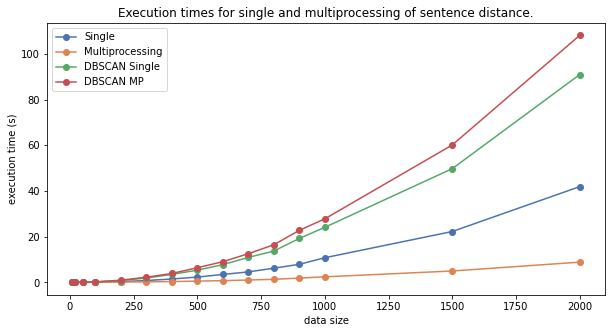

In [54]:
sns.set_palette("deep")
plt.figure(figsize=(10,5))
plt.title('Execution times for single and multiprocessing of sentence distance.')
plt.plot(sizes, times_simple, 'o-')
plt.plot(sizes, times_mp, 'o-')
plt.plot(sizes, times_dbscan, 'o-')
plt.plot(sizes, times_dbscan_mp, 'o-')
plt.legend(['Single', 'Multiprocessing', 'DBSCAN Single', 'DBSCAN MP'])
plt.xlabel('data size')
plt.ylabel('execution time (s)')
plt.savefig('images/performance_gain.png')
plt.show()

We can clearly decide that using the custom multiprocessing function is the one that will save us the biggest ammount of time. So we will proceed with this path.

## **Actual Distance Matrix Processing**

In [23]:
print(data_p.shape)

# No need to recalculate distances from equal senteces.
data_unique = data_p.drop_duplicates(subset='description_clean', keep='first').copy()
print(data_unique.shape)

(95916, 3)
(50131, 3)


In [25]:
%%time

run_mp = False

if run_mp:
    X = np.asarray(data_unique['description_clean'])

    # Multiprocessing
    FINAL_OUTPUT_RAW = np.zeros((len(X), len(X)), dtype=np.int8)
    C_TYPE_OUTPUT = np.ctypeslib.as_ctypes(FINAL_OUTPUT_RAW)
    SHARED_ARRAY = sharedctypes.RawArray(C_TYPE_OUTPUT._type_, C_TYPE_OUTPUT)

    pool = Pool(processes=cpu_count())
    args = [(i, X) for i in range(len(X))]
    res = pool.starmap(apply_leven_mp, args)
    FINAL_OUTPUT_MP = np.ctypeslib.as_array(SHARED_ARRAY)
    np.save("distance_matrix.npy", FINAL_OUTPUT_MP)
else:
    FINAL_OUTPUT_MP = np.load("distance_matrix.npy")
    print('Previous Wall time: 2h 12min 25s')

print("=========FINISHED==========")

Previous Wall time: 2h 12min 25s
=========FINISHED==========
CPU times: user 98.5 ms, sys: 1.09 s, total: 1.19 s
Wall time: 2.45 s


In [26]:
FINAL_OUTPUT_MP += FINAL_OUTPUT_MP.T

In [51]:
%%time
kneighbors = np.zeros((len(FINAL_OUTPUT_MP), 10), dtype=np.int32)

for i in range(len(FINAL_OUTPUT_MP)):
    if (np.where((np.sort(FINAL_OUTPUT_MP[i])[0:11])==100)[0]).size != 0:
        end = np.where((np.sort(FINAL_OUTPUT_MP[i])[0:11])==100)[0][0]
    else:
        end = None
    
    kneighbors[i] = np.delete(np.argsort(FINAL_OUTPUT_MP[i])[0:11],np.where(np.argsort(FINAL_OUTPUT_MP[i])[0:11]==i))
    if end:
        kneighbors[i,end-1:] = -1

CPU times: user 1min 8s, sys: 0 ns, total: 1min 8s
Wall time: 1min 8s


In [52]:
data_unique[data_unique.Material.str.contains('\D')]

,Material,MaterialDescription,description_clean


This shows that all material codes are made of numbers, so we will use an integer array to store the neighbors by their material ID. This is required since indices will change when using the whole dataset instead of only the uniques.

In [53]:
for i in range(len(kneighbors)):
    kneighbors[i][:len(np.delete(kneighbors[i],np.where(kneighbors[i]==-1)))] = np.asarray(data_unique.iloc[np.delete(kneighbors[i],np.where(kneighbors[i]==-1)),0])

In [ ]:
data_unique = pd.concat([data_unique.reset_index(drop=True), pd.DataFrame(kneighbors)], axis=1)
data_unique.head()

In [ ]:
data_p = data_p.merge(data_unique.iloc[:,2:], how='inner', on='description_clean')
data_p.head()

# Testing the Search

In [57]:
def get_similar_items(q, df):
    print("query: ", q)
    search_items = df.description_clean
    distances = np.empty((len(search_items),))
    for i, item in enumerate(search_items):
        distances[i] = dist_sentence(q, item)
    return df.iloc[np.argsort(distances)[0:10],:2]

In [ ]:
get_similar_items('waser', data_p) # By mistake the user types 'waser' instead of 'washer', but it still works

In [95]:
def get_related_items(q, df):
    print("selected item: ", q)
    return df[df.Material.isin([str(x) for x in df.iloc[:,3:][df.Material==q].iloc[0].tolist()])].iloc[:,:2]

In [97]:
get_related_items('40182206', data_p)

selected item:  40182206


,Material,MaterialDescription
8129,40002224,WASHER DIN127 1/4
8909,40002879,RUBBER WASHER 13 -261115-0
13849,40005953,FLASHER
17334,40010091,THRUST WASHER
23663,40038466,SLASHER
34386,40118733,NUTS + WASHERS M12
40413,40156176,COUPLING WASHER
43083,40167678,WASHER M20 CLASS 8.8
48533,40178998,NAILS WITH WASHER
82310,40341129,WASHER P 18 (ALUMINUM/VULCANIZED)
